In [ ]:
#company hierarchy

In [2]:
import pandas as pd

import plotly.graph_objects as go

import networkx as nx
import ast
%matplotlib inline  
#from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("company_master_table.csv", 
                   dtype={"child_cw_id_list" :'str',
                          "parent_cw_id_list": 'str'}, converters={1:ast.literal_eval})

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
CW_ID = 'cw_id'
INDUSTRY_NAME = 'industry_name'
SECTOR_NAME = 'sector_name'
NUM_PARENTS = 'num_parents'
NUM_CHILDREN = 'num_children'
TOP_PARENT_ID = 'top_parent_id'
COMPANY_NAME = 'company_name'
CHILD_CW_ID_LIST = 'child_cw_id_list'
PARENT_CW_ID_LIST = 'parent_cw_id_list'


In [5]:
def list_parse(s):
    strings = str(s).strip("[]").split(",")
    ls = []
    for i in strings:
        try:
            ls.append(int(float(i.strip())))
        except (ValueError):
            ""
    return ls

In [6]:
data[CHILD_CW_ID_LIST] = data[CHILD_CW_ID_LIST].apply(lambda x: list_parse(x))
data[PARENT_CW_ID_LIST] = data[PARENT_CW_ID_LIST].apply(lambda x: list_parse(x))

In [68]:
families = data[((data[NUM_PARENTS]> 0) | (data[NUM_CHILDREN] > 0))]  #i might not want to do this

def replace_missing(x, v):
    if str(x) == 'nan':
        return v
    else:
        return x
families[INDUSTRY_NAME] = families[INDUSTRY_NAME].apply(lambda x: replace_missing(x, "Unknown Industry"))
families[SECTOR_NAME] = families[SECTOR_NAME].apply(lambda x: replace_missing(x, "Unknown Sector"))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [69]:
#join with the location 
location = pd.read_csv('corpwatch_api_tables_csv/company_locations.csv', sep = "\t", escapechar='\\')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.



row_id
sector_name                       top_parent_id         
Agricultural production- crops    14966          2717588
                                  37308          2898241
                                  240882         3080397
                                  348491         3323815
                                  687788         3633093
...                                                  ...
Wholesale trade--nondurable goods 762331         3695114
                                  784040         3734441
                                  892491         3845753
                                  935948         3875010
                                  946519         3888869

[14105 rows x 1 columns]

In [70]:
location.columns

Index(['location_id', 'cw_id', 'date', 'type', 'raw_address', 'street_1',
       'street_2', 'city', 'state', 'postal_code', 'country', 'country_code',
       'subdiv_code', 'min_year', 'max_year', 'most_recent'],
      dtype='object')

In [71]:
def unique_non_nan(elem):
    return [a for a in list(pd.unique(elem))]
#maybe shouldn't just take the first one 
location_filtered = location[location['max_year'] > 2018]
location_aggregations = {'city': "first",
                         'state': "first",
                         'country_code':  "first"}
location_agg = location_filtered.groupby('cw_id').agg(location_aggregations)
#location_df = location_filtered[['cw_id', 'city', 'state', 'country_code']]

,cw_id,row_id
top_parent_id,,
1,"[124905, 124906, 124907, 124908, 442465, 49206...",9
2,"[185844, 198285, 198286, 198287, 198288, 19828...",30
3,"[101328, 101408, 101414, 101418, 101420, 10158...",1275
11,"[410178, 410392, 410393, 410394, 410395, 41039...",51
13,"[124888, 124889, 124890, 737227, 834641]",5
...,...,...
1079926,"[854044, 1116949, 1117034, 1119095, 1119132]",5
1079933,[1117532],1
1082663,"[1116924, 1116933, 1116938, 1116939, 1117003, ...",80


In [73]:
families_location = pd.merge(families, location_agg,
                     left_on='cw_id', 
                     right_on='cw_id',
                     how='left')

In [74]:
families_location.head()

,Unnamed: 0,row_id,cw_id,most_recent,year,cik,irs_number,best_location_id,sic_code,industry_name,...,top_parent_id,company_name,max_year,min_year,no_sic,child_cw_id_list,parent_cw_id_list,city,state,country_code
0,0,18,37,1,2019,3153,630004250.0,74,4911.0,Electric services,...,37,ALABAMA POWER CO,2019,2003,0,"[1665, 993179, 101861, 1018259, 781, 101870, 1...","[12009, 22569, 781, 1197, 1665]",BIRMINGHAM,AL,US
1,1,24,45,1,2019,3499,510100517.0,88,6798.0,Real estate investment trusts,...,9019,ALEXANDERS INC,2019,2003,0,"[1038175, 1038176, 1038177, 1038178, 1038179, ...","[14480, 9019]",PARAMUS,NJ,US
2,2,39,69,1,2019,4515,131502798.0,137,4512.0,"Air transportation, scheduled",...,105,AMERICAN AIRLINES INC,2019,2003,0,"[964843, 964842, 411832, 411833, 416126, 41613...",[105],FT WORTH,TX,US
3,3,65,120,1,2019,6879,540124790.0,246,4911.0,Electric services,...,75,APPALACHIAN POWER CO,2019,2003,0,"[993634, 834826, 696650, 992937, 136825, 95658...","[956587, 1029138, 75, 927, 1345, 1492, 1674]",COLUMBUS,OH,US
4,4,79,130,1,2019,7323,831918668.0,273,4911.0,Electric services,...,1180,ENTERGY ARKANSAS LLC,2019,2003,0,"[899487, 1001712, 1180]",[590084],LITTLE ROCK,AR,US


In [75]:
indexed_groups = families_location.set_index(CW_ID) ## should not use the filtered list 

In [76]:
family_groups = families_location.groupby(families_location[TOP_PARENT_ID])

In [144]:
def create_location_string(row):
    country = row['country_code']
    city = row['city']
    if str(country) == 'US':
        state = row['state']
        return str(city) + ", " + str(state)
    elif str(country) == 'nan':
        return "unknown location"
    else:
        return str(city) + ", " + str(country)

In [145]:
import math

def print_grouped_columns(df, column_name, sortby, limit = 100):      
    for (g, data) in df:
        print(g)
        d = data.sort_values(by = sortby)                        
        for (i,c) in d.iterrows():
            print("\t \t \t " + str(c[column_name]) + " (" +  create_location_string(c) +" )") 


In [146]:
def get_name_by_id(index_df, cw_id):
    row = index_df.loc[cw_id]
    return row[COMPANY_NAME]

In [147]:
def create_top_parent_report(group_df, company_id, name_string):
    agg_dictionary = {"row_id" : "count",
                  CW_ID: unique_non_nan,
                  COMPANY_NAME: unique_non_nan,
                 }
    COMPANY_COUNT = "company_count"
    industry_df_group = group_df.groupby(by = "industry_name")
    
    industry_df = industry_df_group.agg(agg_dictionary)
    industry_df.rename(columns = {"row_id": COMPANY_COUNT}, inplace = True)
    top_industries_df = industry_df.sort_values(by = COMPANY_NAME, ascending=False)
    top_industries = [k for k in top_industries_df[COMPANY_COUNT].to_dict().keys()]
   
    sectors = group_df.groupby(SECTOR_NAME).count() 
    sectors.rename(columns = {"row_id": COMPANY_COUNT}, inplace = True)
    subsidiaries = group_df[COMPANY_NAME]

    sub = [x for x in subsidiaries]
    print("Parent company information "  + str(name_string)) 
    print("* Has " + str(len(subsidiaries)) + " subsidiaries")
    
    #change to take the top 3 or so industries if they exist 
    print("* Top industries " + str(top_industries))
    
    # needs to be renamed to the count
    industry_df.plot.pie(y = COMPANY_COUNT, legend = False, title = "Subsidiaries By Industry") 
    plt.show()
    
    sectors.plot.pie(y = COMPANY_COUNT, legend = False, title = "Subsidiaries by Sector")
    plt.show()
    
    locations = group_df.groupby('country_code').agg(agg_dictionary)
    l = [k for k in locations['row_id'].to_dict().keys()]
    print("Subsidiaries locations: " + str(set(l)))
    print("==================== SUBSIDIARIES BY INDUSTRY ============================= ")
    print_grouped_columns(industry_df_group, COMPANY_NAME, NUM_CHILDREN, limit = 100)
 

In [148]:
def generate_company_report(company_id):
    co_name = get_name_by_id(indexed_groups, company_id)
    row = indexed_groups.loc[company_id]
    industry = row[INDUSTRY_NAME]
    parents = row[PARENT_CW_ID_LIST]
    top_parent = row[TOP_PARENT_ID]
    top_parent_name = get_name_by_id(indexed_groups, top_parent)
    print("Company: " + str(co_name) + "  company_id: " + str(company_id))
    print("Location: " + create_location_string(row))    
    print("=====================")
    print("")
    #size by industry, number of subsidiaries

    if top_parent != company_id:
        if top_parent in parents:
            print("* t is a subsidiary of: " + str(top_parent_name) + " (" + str(top_parent) + ")")
        else:
            print("* is owned by " + str(parents))
            print("* is an indirect subsidiary of  ")
            print("* is a subsidiary of: " + str(top_parent_name) + " " + str(top_parent) + ")")
        #Ask the user if they would like to see the top parent report before showing it? 
        
        if float(row[NUM_CHILDREN]) > 0.0:
            children = row[CHILD_CW_ID_LIST]
            print("* owns " + str(children) + " companies")

    group = family_groups.get_group(top_parent)   
    create_top_parent_report(group, top_parent, top_parent_name)
    
    #wish list 
    #is a multinational
    #ranking by industry
    #number of child locations
    #subsidiaries locations


Company: ALABAMA POWER CO  company_id: 37
Location: BIRMINGHAM, AL

Parent company information ALABAMA POWER CO
* Has 6 subsidiaries
* Top industries ['Electric services', 'Unknown Industry']


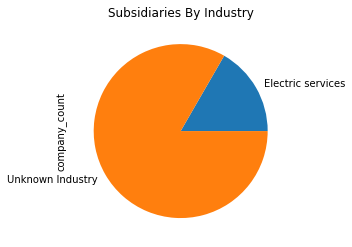

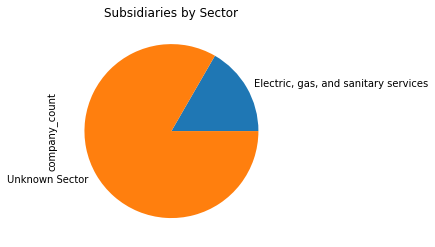

Subsidiaries locations: {'US'}
==================== SUBSIDIARIES BY INDUSTRY ============================= 
Electric services
	 	 	 ALABAMA POWER CO (BIRMINGHAM, AL )
Unknown Industry
	 	 	 ) Georgia Pacific Belux S.P.R.L. (unknown location )
	 	 	 D) Troy Fibers Ltd (unknown location )
	 	 	 E) Ivandon Holding Oy (unknown location )
	 	 	 F) Nokian Palkallispal Velutoy (unknown location )
	 	 	 . Georgia Pacific Iberia Holdings SL (unknown location )


In [149]:
generate_company_report(37)

generate_company_report(781)

In [ ]:
family_graph = {}

from collections import defaultdict
#Loop through the top parent ids
#relationships are parent ---> child 
from collections.abc import Iterable   # import directly from collections for Python < 3.3
failed_rows = 0
for name, group in family_groups:
    G = nx.DiGraph()
    for index, row in group.iterrows():
        cw_id = int(row[CW_ID])
        children = row[CHILD_CW_ID_LIST]
        parents = row[PARENT_CW_ID_LIST]
        try:
            for c in children:
                if(c != cw_id):
                    G.add_edge(cw_id, c)
            for p in parents:
                if p != cw_id:
                    G.add_edge(p, cw_id)
        except (ValueError):
            print("?")
        family_graph[name] = G


In [ ]:
#H.add_nodes_from([1,3,4,5])
import math
J = nx.DiGraph()
J.add_edges_from([(1,2.0), (3, 2) , (3,4), (int(8.0), 9)])

In [ ]:
%matplotlib inline  
#from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt
def plot_graph(G):
    nx.draw_shell(G, with_labels=True)
    plt.show()
g = family_graph[130]

plot_graph(J)

In [ ]:
family_graph[37].edges

In [ ]:
g.subgraph([75, 120]).edges

In [ ]:
get_name_by_id(indexed_groups, 37)

Company: PEPSICO INC  company_id: 1419
Location: PURCHASE, NY

Parent company information PEPSICO INC
* Has 1777 subsidiaries
* Top industries ['Beverages', 'Unknown Industry']


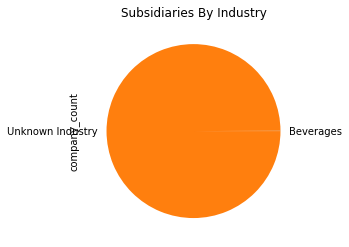

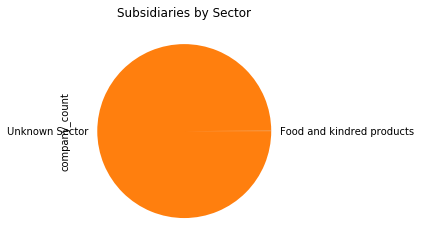

Subsidiaries locations: {'IL', 'KG', 'GI', 'TW', 'UY', 'CZ', 'RU', 'KR', 'GT', 'CR', 'NI', 'CH', 'AU', 'VN', 'LT', 'IN', 'TR', 'SA', 'HK', 'TH', 'CA', 'KY', 'EE', 'BY', 'SK', 'BR', 'PE', 'NL', 'PY', 'NO', 'AZ', 'BM', 'UA', 'LI', 'EG', 'US', 'EC', 'LV', 'AM', 'IE', 'CN', 'MX', 'PH', 'RS', 'LU', 'PT', 'NZ', 'PL', 'RO', 'ID', 'MU', 'BA', 'CO', 'SG', 'AR', 'NG', 'BB', 'FI', 'CL', 'BE', 'DK', 'PK', 'TT', 'DE', 'DO', 'FR', 'BO', 'GR', 'IT', 'BD', 'CY', 'SV', 'MY', 'ZA', 'GB', 'HN', 'KZ', 'AT', 'MA', 'PA', 'JP', 'ES', 'AE', 'HU'}
==================== SUBSIDIARIES BY INDUSTRY ============================= 
Beverages
	 	 	 PEPSICO INC (PURCHASE, NY )
Unknown Industry
	 	 	 Bermuda Holdings LLC (unknown location )
	 	 	 Matutano Sociedade de Produtos Alimentares Unipessoal Lda (unknown location )
	 	 	 Marbo Produkt d.o.o. (unknown location )
	 	 	 Marbo d.o.o. Laktasi (nan, BA )
	 	 	 Malpensa Consultadoria e Servicos Sociedade Unipessoal. Lda. (unknown location )
	 	 	 Lebedyansky Holding Co (

In [151]:
generate_company_report(1419)